# MRI QA Summary Reports

In [1]:
from __future__ import division, print_function

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from mriqa.dcmio import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, distortion_report,
    resolution_bars_report, uniformity_report, snr_report
)
from mriqa.phantoms import TO2B, TO4C, SIEMENSSHORTBOTTLE

## Slice Profile

The TO2B phantom has only a single pair of crossed plates  (unlime TO2 which has two pairs crossed plates and two pairs of wedges). Here we use the crossed plates to estimate the full-width half maximum of the slice profile for 5mm and 3mm slices as described in the IPEM *green book*.

To go from the width of the profile in the image to the true width mm we need to scale by both the pixel size and by the tangent of the plate angle. Normally this is taken to be 11.7&deg; but is not known for TO2B. We'll choose an arbitrary value (44&deg;) for now - the slices widths will not be calibrated, though the form of the line profile is unaffected.

So as to facilitate the analysis we interpolate the images to higher resolution first. Having extracted the thick profiles we fit a quadratic bias to the start and the end of the profile assuming this is outside of the plate and is just the gain field for the background liquid in the phantom. We divide the profiles by this modelled gain variation and also invert them to give a positive going *line shape*.

This is fitted using cubic splines and the half height position found to determine the FWHM which is then scaled appropriately for pixel size and plate projection.

Although we correct for non-uniformity below, it is better to use prescan normalised images to limit the bias field in the background of the image. It is also helpful to have a reasonably high resolution image - in this case we have a 512<sup>2</sup> acquisition.

Having a pairs of plates provides for some degree of rubustness to misalignment of the phantom, but again it is advisable to minimise this as much as possible.

### 3 mm Slice

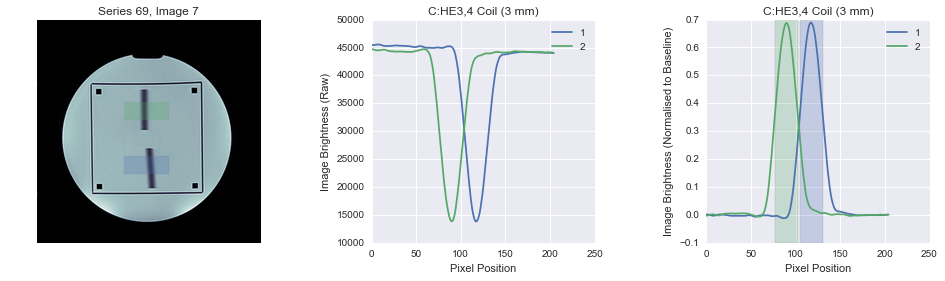

Plate Angle  =  44.0 degrees
FWHM     (1) =  26.3 pixels, or 6.2 mm
FWHM     (2) =  26.4 pixels, or 6.2 mm
FWHM (GMEAN) =  26.4 pixels, or 6.2 mm


In [2]:
# TO2B: Slice 3mm
patid = 'PQABRY20151114'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[69])
slice_idx = 6
# Guess the plate angle
results = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False, plate_angle=44, phantom=TO2B)

### 5 mm Slice

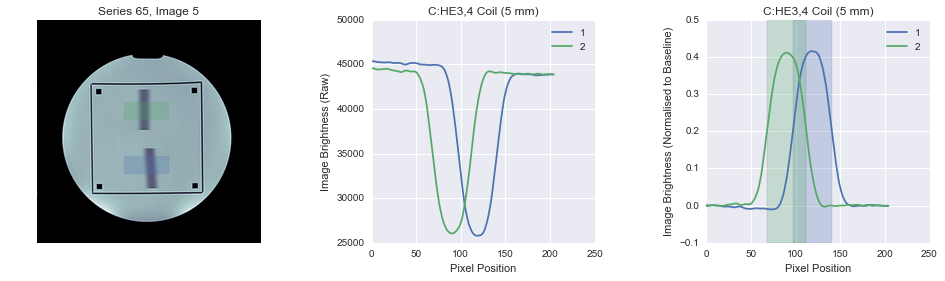

Plate Angle  =  44.0 degrees
FWHM     (1) =  43.0 pixels, or 10.1 mm
FWHM     (2) =  43.6 pixels, or 10.3 mm
FWHM (GMEAN) =  43.3 pixels, or 10.2 mm


In [3]:
# TO2B: Slice 5mm

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[65])
slice_idx = 4
# Guess the plate angle
result = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False, plate_angle=44, phantom=TO2B)
results = results.append(result)

In [4]:
results[['FWHMGMeanPixels', 'FWHMGMeanMM']]

FWHMGMeanPixels  FWHMGMeanMM
SliceThickness                              
3.0                   26.383253     6.220218
5.0                   43.316865    10.212551

## Geometric Distortion and Scaling

The TO2B phantom also has an approximately 120 mm square box for distortion measurements. Here we use this to estimate the in plane scale (aka *linearity*) and the relative distortion as described in the IPEM Report 80 *green book*. It is best to use the thinner 3mm slice series for this to minimise the blurring from misalignment. We choose a slice in the middle of the block.

In addition, if scans are available at 512x512 rather than 256x256 this will allow more accurate determination of the distortion but note that in this case the bandwidth should be scaled down by a factor of two so as to obtain the same sensitivity to off-resonance distortion. The scans should be acquired with the phase encoding direction both along columns and along rows to separate out off-resonance effects from the gradient spatial non-linearity.

After centring the phantom we extract an ROI for the box using its expected position in the phantom. The central area is occupied by the wedges and plates so we fill this with the phantom background intensity so it doesn't interfere with profiles across the ROI.

Then, to get smoother and more easily locatable peaks in the profiles, we interpolate the image to higher resolution using the `scipy.ndimage` image `zoom` function. 

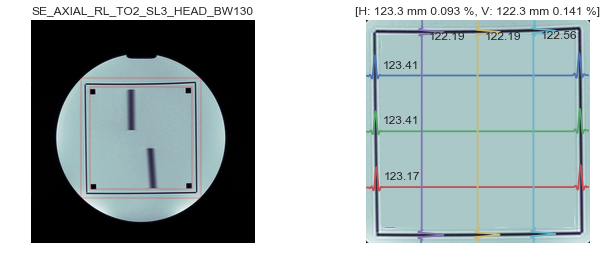

Horizontal Scale / Distortion:    123.3 mm / 0.09 %
Vertical Scale / Distortion:      122.3 mm / 0.14 %


In [5]:
# TO2B: Distortion
# SE: Axial, Phase RL, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[68])

slice_idx = len(dobjs)//2
results = distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False, phantom=TO2B)

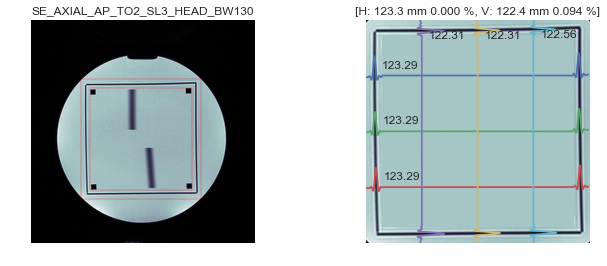

Horizontal Scale / Distortion:    123.3 mm / 0.00 %
Vertical Scale / Distortion:      122.4 mm / 0.09 %


In [6]:
# TO2B: Distortion
# SE: Axial, Phase AP, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[70])

slice_idx = len(dobjs)//2
results = results.append(distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False, phantom=TO2B))

In [7]:
results[
    ['Orientation', 'PhaseDirection', 'Sensitivity',
     'HorizontalScale', 'HorizontalDistortion',
     'VerticalScale', 'VerticalDistortion']
]

Orientation PhaseDirection  Sensitivity  HorizontalScale  \
Series                                                            
68           Axial             RL     0.239213       123.331706   
70           Axial             AP     0.239213       123.291016   

        HorizontalDistortion  VerticalScale  VerticalDistortion  
Series                                                           
68                  0.093317     122.314453            0.141139  
70                  0.000000     122.395833            0.094030

## Spatial Resolution

The resolution is assessed here using the TO4C phantom, which has parallel plates of various separations as well as a single MTF block and a resolution *fan*. Here we'll just use the plates. As it is very difficult to align the phantom so that the plates are exactly along a pixel axis we automatically realign the images before projecting along the plate direction to give an average profile across the plates. We present the results for the highest resolution scan (1024x10124).

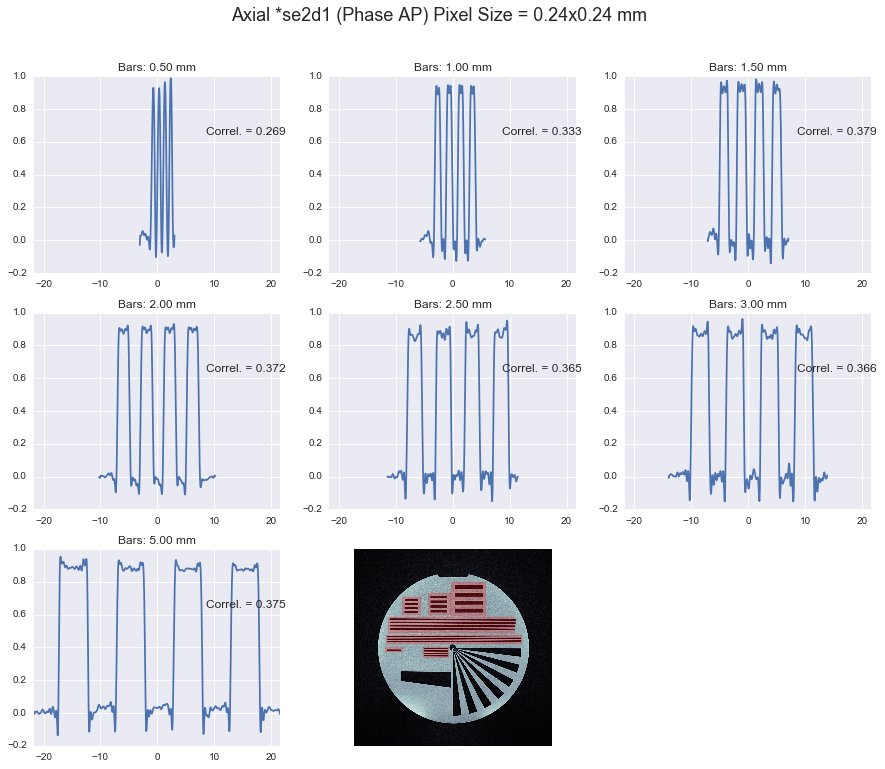

In [8]:
# TO4C: Resolution
dobjs = fetch_series(patid, stuid, sernos=[85])
slice_idx = 0
result = resolution_bars_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False, phantom=TO4C)

## Ghosting

To test for image ghosting we follow the approach of the [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) and look for image intensity outside a symmetrically positioned phantom. This is sensitive to Nyquist ghosting in EPI scans and scattered ghosts due to phase instabilities in fast spin echo. We present the values here for the transverse orientation.

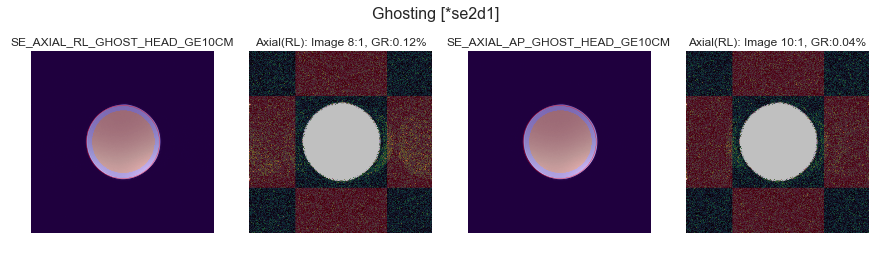

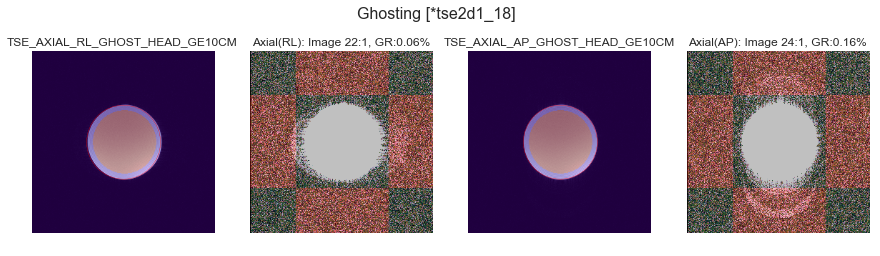

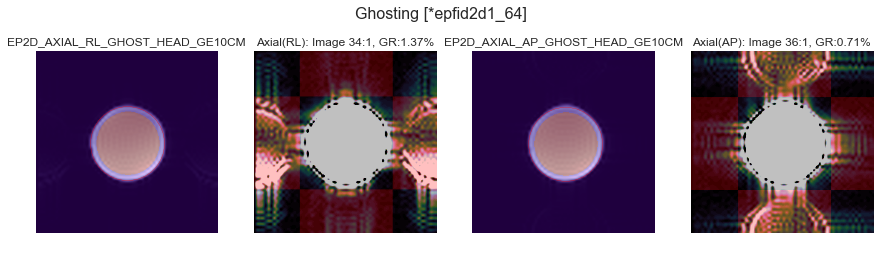

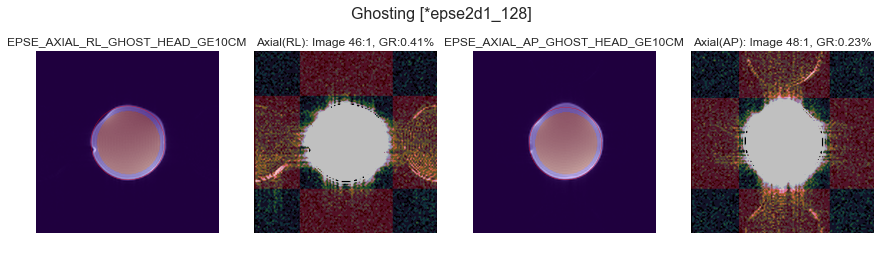

Sequence Orientation PhaseDirection  GhostRatio
Series                                                     
8             *se2d1       Axial             RL    0.119369
10            *se2d1       Axial             RL    0.041398
22        *tse2d1_18       Axial             RL    0.060640
24        *tse2d1_18       Axial             AP    0.156827
34      *epfid2d1_64       Axial             RL    1.365157
36      *epfid2d1_64       Axial             AP    0.705141
46      *epse2d1_128       Axial             RL    0.412676
48      *epse2d1_128       Axial             AP    0.232360

In [9]:
# GE10CM: Ghosting
# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in  [8, 10]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# GE10CM: Ghosting
# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [22, 24]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# GE10CM: Ghosting
# EPIFID64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [34, 36]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# GE10CM: Ghosting
# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [46, 48]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

display(results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']])

## Receiver Coil Uniformity

We test the uniformity of the head coil (either the standard coil or the advanced neuro depending on what is normally used). We use normally use a silicone oil filled spherical phantom so as to avoid B<sub>1+</sub> shading effects at 3T. With that we can provide uniformity profiles along all axes. Here we have used water bottle phantom. A water phantom is acceptable here as the field strength is only 1.5T. However, as the phantom is cylindrical we we present uniformity measurements in the transverse plane only. We obtain images both with and without prescan based intensity normalisation (this can be done in a single acquisition on Siemens systems). The analysis is based on the green book method. Results are presented both before and after `prescan-normalise` intensity correction.

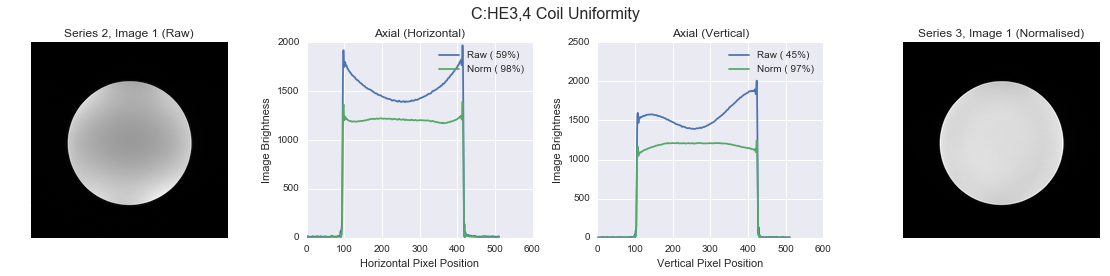

In [10]:
# Uniformity
# SE Axial Only; w w/o Intensity Normalization
raw_tra = fetch_series(patid, stuid, sernos=[2])
psn_tra = fetch_series(patid, stuid, sernos=[3])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0]],
        psn_dobjs=[psn_tra[0]],
        raw_dobjsb=[raw_tra[1]],
        psn_dobjsb=[psn_tra[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0]],
        psn_dobjs=[psn_tra[0]]
    )

In [11]:
print('Raw Images')
display(results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']])
print('Intensity Normalised Images')
display(results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']])

Raw Images


SeriesRaw                                        ProtocolRaw OrientRaw  \
Axial          2  SE_AXIAL_RL_SNR_UNIF_HEAD_SiemensCylindrical_T...  Axial/RL   

       XUniformityRaw  YUniformityRaw  
Axial       59.442724       45.201238

Intensity Normalised Images


SeriesNorm                                       ProtocolNorm  \
Axial           3  SE_AXIAL_RL_SNR_UNIF_HEAD_SiemensCylindrical_T...   

      OrientNorm  XUniformityNorm  YUniformityNorm  
Axial   Axial/RL         97.52322        97.213622

## Signal to Noise Ratio

We test the signal to noise ratio of the head coil (either the standard coil or the advanced neuro depending on what is normally used). We normally use the Siemens long bottle phantom as this has a holder allowing it to be reproducibly positioned. Here the an aternative larger bottle (160mm diameter) has been used, which we've denoted the Siemens short bottle.

We take a single global value for the image noise obtained from the standard deviation of the difference image. This assumes that the noise is spatially uniform, which is probably reasonable if there has been no intensity normalization or non-linear filtering. We consider only the region outside the phantom for this so as to minimise the effect of subtraction artefacts within the phantom.

In addition, as the noise uniformity may also dependent on any non-linearity in the the coil combination method we use only the basic sum of squares mode rather than the Siemens *adaptive* recombination.

The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. 

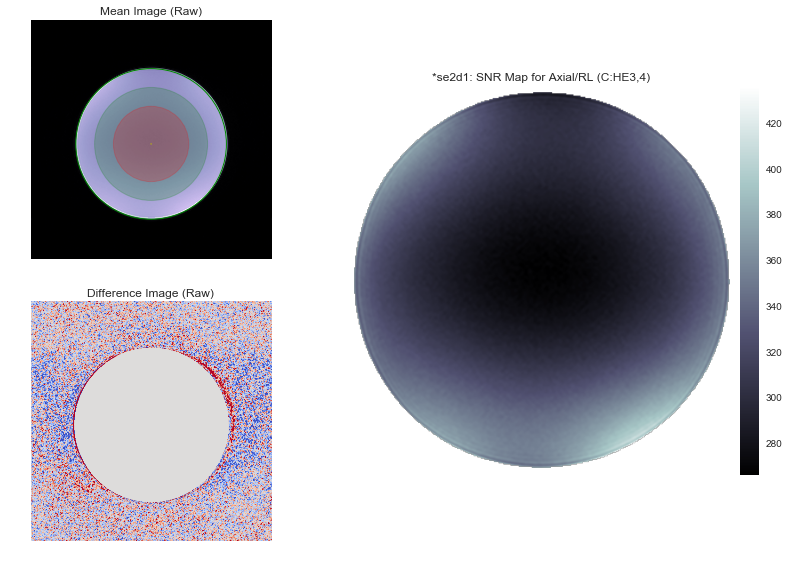

In [12]:
# Signal to Noise ('SHORTBOTTLE')
raw_tra = fetch_series(patid=patid, stuid=stuid, sernos=[2])
results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]], phantom=SIEMENSSHORTBOTTLE)

It appears that there is some structure in the background noise image along the RL axis, possibly from non stationary ghosting or some image processing artefact. Currently, we use the variance of the whole of the region outside the phantom to estimate the noise but in view of this structure it might be better to use only specific regions such as the image corners.

In [13]:
print('SNR: Raw Images')
display(results)

SNR: Raw Images


C:HE3,4
0.50  283.688780
0.75  299.666944